In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [81]:
import json
import re
import matplotlib

# 한글 품사 태깅을 위한 모듈
from konlpy.tag import Okt
from collections import Counter
from matplotlib import font_manager, rc
from wordcloud import WordCloud

plt.rcParams['font.family'] = 'NanumGothic'

In [82]:
file2 = '../변수정리/csv파일/final_data_set_v3.csv'

In [83]:
# final_data_set_v2.csv 열기 --> 정답 데이터를 일단 분석해보기
# 왜냐면 나눈 것이 잘 나눠졌나 확인하려고
raw1 = pd.read_csv(file2, index_col=0)
df1 = raw1.copy()
df1.head(1)

,Attraction,Category,type,Category_Map,Category_Map_v2,Good_Point,Selected_People,Selected_People_Ratio,Participants,Address,Tag,Longitude,Latitude,Image Link
0,104고지전적비,관광,history,매력도,분위기,사진이 잘 나와요,91.0,0.250689,203,서울특별시 서대문구 연희동 산100-1,#관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...,126.926214,37.567794,https://dbscthumb-phinf.pstatic.net/2765_000_1...


In [84]:
# 아직 분류 전 DF : 사용할 Tag만 사용
df_tag = df1[['Attraction', 'Category', 'Tag']].drop_duplicates().reset_index(drop=True)
print(df_tag.shape)
df_tag.head(2)

(785, 3)


,Attraction,Category,Tag
0,104고지전적비,관광,#관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...
1,10꼬르소꼬모 청담점,관광,#10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...


In [85]:
df_tag['Category'].value_counts()

Category
음식    449
관광    336
Name: count, dtype: int64

In [86]:
df_tag['Category'] == '관광'

0       True
1       True
2       True
3       True
4       True
       ...  
780    False
781    False
782    False
783    False
784    False
Name: Category, Length: 785, dtype: bool

In [87]:
df_tag_tour = df_tag[df_tag['Category'] == '관광']
df_tag_food = df_tag[df_tag['Category'] == '음식']

In [88]:
df_tag_tour.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336 entries, 0 to 335
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Attraction  336 non-null    object
 1   Category    336 non-null    object
 2   Tag         336 non-null    object
dtypes: object(3)
memory usage: 10.5+ KB


In [89]:
df_tag_food.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449 entries, 336 to 784
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Attraction  449 non-null    object
 1   Category    449 non-null    object
 2   Tag         449 non-null    object
dtypes: object(3)
memory usage: 14.0+ KB


In [91]:
df_tag_tour

,Attraction,Category,Tag
0,104고지전적비,관광,#관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...
1,10꼬르소꼬모 청담점,관광,#10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...
2,63아트,관광,#63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...
3,가락농수산물종합도매시장,관광,#가락농수산물도매시장#가락시장#가족여행#나들이#나홀로여행#데이트코스#도심여행#먹거리...
4,가락몰,관광,#가락몰#가락몰도서관#송파수산시장#쇼핑#식자재시장#식재료쇼핑몰
...,...,...,...
331,IFC몰,관광,#IFC몰#복합쇼핑몰#쇼핑#수도권#여의도대형쇼핑몰#여의도복합쇼핑몰#여의도쇼핑#여의도...
332,KCDF 갤러리숍 공예정원,관광,#갤러리숍#공예#공예품#디자인#디자인상품#쇼핑
333,KT&G 상상마당 디자인스퀘어,관광,#기념품#문화활동#복합문화공간#쇼핑#외국인친구에게추천#홍대
334,N서울타워,관광,#19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...


### 태그 전처리

In [92]:
# 함수 만들기
def make_newTagCols(df, nlp):
    # tag 분리한거 담는 컬럼 만들기
    df[['newTag', 'newTag_list', 'tag_word_N']] = None
    # 모든 태그 모음집
    total = ''
    # 모든 태그의 명사 추출 모음집
    N_list = []

    # '#' 분리해서 컬럼에 담기
    for i, tag in enumerate(df.Tag):
        tag = tag.split('#')[1:]
        df['newTag_list'][i] = tag
    
        words = ''
        for t in tag:
            words = words + t + ' '
    
        total = total + words + ' '
        df['newTag'][i] = words

        # 명사 추출해서 또 새로운 컬럼에 담기
        newTag_N = list(set(nlp.nouns(words)))
        N_list.append(newTag_N)
        df['tag_word_N'][i] = newTag_N
        
    # '#'제거 해시태그 한 리스트에 모은 것 : total
    # total에서 명사 추출한 결과
    total_nouns = nlp.nouns(total)

    return df, total, N_list, total_nouns

관광부터 추출 & 시각화

In [93]:
# 한글 단어 구분
nlp = Okt()

df_tag_tour, total_word, newTag_N_list, total_nouns = make_newTagCols(df_tag_tour, nlp)

In [94]:
df_tag_tour.head(2)

,Attraction,Category,Tag,newTag,newTag_list,tag_word_N
0,104고지전적비,관광,#관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...,관광지 기념탑 역사 역사공부 역사관광지 역사를품은곳 역사문화재 역사속 역사속으로 역...,"[관광지, 기념탑, 역사, 역사공부, 역사관광지, 역사를품은곳, 역사문화재, 역사속...","[문화재, 유적지, 한국, 곳, 여행, 탐험, 역사, 공부, 비, 유적, 전쟁, 기..."
1,10꼬르소꼬모 청담점,관광,#10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...,10꼬르소꼬모 10꼬르소꼬모청담점 강남브런치카페 쇼핑 음식 청담동카페 청담동편집숍 ...,"[10꼬르소꼬모, 10꼬르소꼬모청담점, 강남브런치카페, 쇼핑, 음식, 청담동카페, ...","[카페, 청담, 꼬르소꼬모, 꼬르소꼬, 편집, 음식, 브런치, 청담동, 점, 숍, ..."


단어 정제
- 빈출 단어 제거

In [95]:
count = Counter(total_nouns)

In [96]:
word_count = dict()

# 빈출 단어 50위까지 word_count에 넣어주는 코드
for tag, counts in count.most_common(50):
    if (len(str(tag))>1):
        word_count[tag] = counts
        print(f'{tag} : {counts}')

여행 : 393
역사 : 281
관광지 : 182
휴식 : 179
서울 : 159
공원 : 151
시장 : 145
쇼핑 : 141
아이 : 136
문화 : 120
체험 : 110
가족 : 108
박물관 : 103
산책 : 97
친구 : 96
전통 : 93
연인 : 92
수도권 : 78
여행지 : 77
관광 : 76
공간 : 74
한국 : 67
데이트 : 63
도심 : 62
코스 : 58
자연 : 58
실내 : 57
힐링 : 54
시설 : 53
나들이 : 53
체험학습 : 42
여행가 : 36
는달 : 36
발도장 : 36
재래시장 : 35
한강 : 33
이색 : 32
교과서 : 30
유적지 : 29
남녀 : 29
노소 : 29
당일치기 : 29
투어 : 28
근교 : 27
야경 : 25
사계절 : 25
이야기 : 24


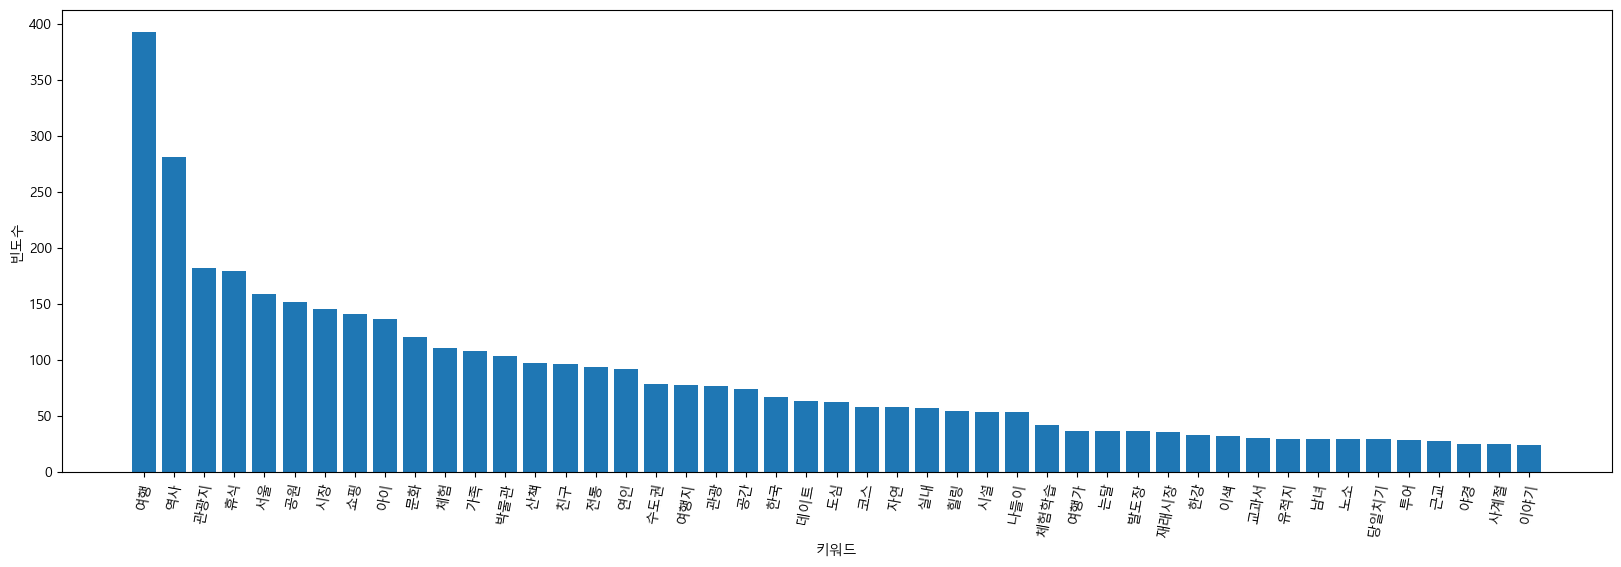

In [97]:
font_path = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
matplotlib.rc('font', family = font_name)

plt.figure(figsize = (20, 6))
plt.xlabel('키워드')
plt.ylabel('빈도수')
# plt.grid(True)

sorted_Keys = sorted(word_count, key = word_count.get, reverse = True)
sorted_Values = sorted(word_count.values(), reverse = True)

plt.bar(range(len(word_count)), sorted_Values, align = 'center')

plt.xticks(range(len(word_count)), list(sorted_Keys), rotation = 80)
plt.show()

In [98]:
df_tag_tour['tag_word_N']

0      [문화재, 유적지, 한국, 곳, 여행, 탐험, 역사, 공부, 비, 유적, 전쟁, 기...
1      [카페, 청담, 꼬르소꼬모, 꼬르소꼬, 편집, 음식, 브런치, 청담동, 점, 숍, ...
2      [전망, 빌딩, 미술관, 전시관, 복합, 아트, 문화, 화공, 시설, 곳, 여행지,...
3      [수산물, 친구, 아이, 맛집, 쇼핑, 전통, 수도권, 농, 연인, 먹거리, 여행,...
4            [식, 도서관, 쇼핑몰, 재료, 송파, 쇼핑, 가락, 식자, 수산시장, 재시]
                             ...                        
331    [여의도, 영등포, 연중, 복합, 쇼핑몰, 대형, 아이에프, 무, 크리스마스, 쇼핑...
332                       [갤러리, 상품, 공예, 숍, 쇼핑, 공예품, 디자인]
333           [기념품, 친구, 복합, 공간, 문화, 추천, 쇼핑, 홍대, 활동, 외국인]
334    [명소, 전망, 친구, 아이, 사계절, 야간, 는달, 수도권, 선, 한국, 여행지,...
335    [용품, 시점, 문구점, 팬, 상품, 박스, 아트, 점, 신촌, 숍, 쇼핑, 학용품...
Name: tag_word_N, Length: 336, dtype: object

In [99]:
df_tag_tour

,Attraction,Category,Tag,newTag,newTag_list,tag_word_N
0,104고지전적비,관광,#관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...,관광지 기념탑 역사 역사공부 역사관광지 역사를품은곳 역사문화재 역사속 역사속으로 역...,"[관광지, 기념탑, 역사, 역사공부, 역사관광지, 역사를품은곳, 역사문화재, 역사속...","[문화재, 유적지, 한국, 곳, 여행, 탐험, 역사, 공부, 비, 유적, 전쟁, 기..."
1,10꼬르소꼬모 청담점,관광,#10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...,10꼬르소꼬모 10꼬르소꼬모청담점 강남브런치카페 쇼핑 음식 청담동카페 청담동편집숍 ...,"[10꼬르소꼬모, 10꼬르소꼬모청담점, 강남브런치카페, 쇼핑, 음식, 청담동카페, ...","[카페, 청담, 꼬르소꼬모, 꼬르소꼬, 편집, 음식, 브런치, 청담동, 점, 숍, ..."
2,63아트,관광,#63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...,63빌딩전시관 63빌딩전시회 63스퀘어 63아트 경치좋은곳 문화공간 문화시설 문화예...,"[63빌딩전시관, 63빌딩전시회, 63스퀘어, 63아트, 경치좋은곳, 문화공간, 문...","[전망, 빌딩, 미술관, 전시관, 복합, 아트, 문화, 화공, 시설, 곳, 여행지,..."
3,가락농수산물종합도매시장,관광,#가락농수산물도매시장#가락시장#가족여행#나들이#나홀로여행#데이트코스#도심여행#먹거리...,가락농수산물도매시장 가락시장 가족여행 나들이 나홀로여행 데이트코스 도심여행 먹거리 ...,"[가락농수산물도매시장, 가락시장, 가족여행, 나들이, 나홀로여행, 데이트코스, 도심...","[수산물, 친구, 아이, 맛집, 쇼핑, 전통, 수도권, 농, 연인, 먹거리, 여행,..."
4,가락몰,관광,#가락몰#가락몰도서관#송파수산시장#쇼핑#식자재시장#식재료쇼핑몰,가락몰 가락몰도서관 송파수산시장 쇼핑 식자재시장 식재료쇼핑몰,"[가락몰, 가락몰도서관, 송파수산시장, 쇼핑, 식자재시장, 식재료쇼핑몰]","[식, 도서관, 쇼핑몰, 재료, 송파, 쇼핑, 가락, 식자, 수산시장, 재시]"
...,...,...,...,...,...,...
331,IFC몰,관광,#IFC몰#복합쇼핑몰#쇼핑#수도권#여의도대형쇼핑몰#여의도복합쇼핑몰#여의도쇼핑#여의도...,IFC몰 복합쇼핑몰 쇼핑 수도권 여의도대형쇼핑몰 여의도복합쇼핑몰 여의도쇼핑 여의도아...,"[IFC몰, 복합쇼핑몰, 쇼핑, 수도권, 여의도대형쇼핑몰, 여의도복합쇼핑몰, 여의도...","[여의도, 영등포, 연중, 복합, 쇼핑몰, 대형, 아이에프, 무, 크리스마스, 쇼핑..."
332,KCDF 갤러리숍 공예정원,관광,#갤러리숍#공예#공예품#디자인#디자인상품#쇼핑,갤러리숍 공예 공예품 디자인 디자인상품 쇼핑,"[갤러리숍, 공예, 공예품, 디자인, 디자인상품, 쇼핑]","[갤러리, 상품, 공예, 숍, 쇼핑, 공예품, 디자인]"
333,KT&G 상상마당 디자인스퀘어,관광,#기념품#문화활동#복합문화공간#쇼핑#외국인친구에게추천#홍대,기념품 문화활동 복합문화공간 쇼핑 외국인친구에게추천 홍대,"[기념품, 문화활동, 복합문화공간, 쇼핑, 외국인친구에게추천, 홍대]","[기념품, 친구, 복합, 공간, 문화, 추천, 쇼핑, 홍대, 활동, 외국인]"
334,N서울타워,관광,#19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...,19_20한국관광100선 2024_여행가는달과함께하는_발도장여행지 21_22한국관광...,"[19_20한국관광100선, 2024_여행가는달과함께하는_발도장여행지, 21_22한...","[명소, 전망, 친구, 아이, 사계절, 야간, 는달, 수도권, 선, 한국, 여행지,..."


In [100]:
# temp_list = []

# for i in range(len(df_tag_tour)):
#     for j in range(len(df_tag_tour['tag_word_N'][i])):
#         if df_tag_tour['tag_word_N'][i][j] not in word_50:
#             temp_list = temp_list.append(df_tag_tour['tag_word_N'][i][j])
#             df_tag_tour['tag_word_N'][i] = temp_list
#         else:
#             continue

In [101]:
df_tag_tour

,Attraction,Category,Tag,newTag,newTag_list,tag_word_N
0,104고지전적비,관광,#관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...,관광지 기념탑 역사 역사공부 역사관광지 역사를품은곳 역사문화재 역사속 역사속으로 역...,"[관광지, 기념탑, 역사, 역사공부, 역사관광지, 역사를품은곳, 역사문화재, 역사속...","[문화재, 유적지, 한국, 곳, 여행, 탐험, 역사, 공부, 비, 유적, 전쟁, 기..."
1,10꼬르소꼬모 청담점,관광,#10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...,10꼬르소꼬모 10꼬르소꼬모청담점 강남브런치카페 쇼핑 음식 청담동카페 청담동편집숍 ...,"[10꼬르소꼬모, 10꼬르소꼬모청담점, 강남브런치카페, 쇼핑, 음식, 청담동카페, ...","[카페, 청담, 꼬르소꼬모, 꼬르소꼬, 편집, 음식, 브런치, 청담동, 점, 숍, ..."
2,63아트,관광,#63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...,63빌딩전시관 63빌딩전시회 63스퀘어 63아트 경치좋은곳 문화공간 문화시설 문화예...,"[63빌딩전시관, 63빌딩전시회, 63스퀘어, 63아트, 경치좋은곳, 문화공간, 문...","[전망, 빌딩, 미술관, 전시관, 복합, 아트, 문화, 화공, 시설, 곳, 여행지,..."
3,가락농수산물종합도매시장,관광,#가락농수산물도매시장#가락시장#가족여행#나들이#나홀로여행#데이트코스#도심여행#먹거리...,가락농수산물도매시장 가락시장 가족여행 나들이 나홀로여행 데이트코스 도심여행 먹거리 ...,"[가락농수산물도매시장, 가락시장, 가족여행, 나들이, 나홀로여행, 데이트코스, 도심...","[수산물, 친구, 아이, 맛집, 쇼핑, 전통, 수도권, 농, 연인, 먹거리, 여행,..."
4,가락몰,관광,#가락몰#가락몰도서관#송파수산시장#쇼핑#식자재시장#식재료쇼핑몰,가락몰 가락몰도서관 송파수산시장 쇼핑 식자재시장 식재료쇼핑몰,"[가락몰, 가락몰도서관, 송파수산시장, 쇼핑, 식자재시장, 식재료쇼핑몰]","[식, 도서관, 쇼핑몰, 재료, 송파, 쇼핑, 가락, 식자, 수산시장, 재시]"
...,...,...,...,...,...,...
331,IFC몰,관광,#IFC몰#복합쇼핑몰#쇼핑#수도권#여의도대형쇼핑몰#여의도복합쇼핑몰#여의도쇼핑#여의도...,IFC몰 복합쇼핑몰 쇼핑 수도권 여의도대형쇼핑몰 여의도복합쇼핑몰 여의도쇼핑 여의도아...,"[IFC몰, 복합쇼핑몰, 쇼핑, 수도권, 여의도대형쇼핑몰, 여의도복합쇼핑몰, 여의도...","[여의도, 영등포, 연중, 복합, 쇼핑몰, 대형, 아이에프, 무, 크리스마스, 쇼핑..."
332,KCDF 갤러리숍 공예정원,관광,#갤러리숍#공예#공예품#디자인#디자인상품#쇼핑,갤러리숍 공예 공예품 디자인 디자인상품 쇼핑,"[갤러리숍, 공예, 공예품, 디자인, 디자인상품, 쇼핑]","[갤러리, 상품, 공예, 숍, 쇼핑, 공예품, 디자인]"
333,KT&G 상상마당 디자인스퀘어,관광,#기념품#문화활동#복합문화공간#쇼핑#외국인친구에게추천#홍대,기념품 문화활동 복합문화공간 쇼핑 외국인친구에게추천 홍대,"[기념품, 문화활동, 복합문화공간, 쇼핑, 외국인친구에게추천, 홍대]","[기념품, 친구, 복합, 공간, 문화, 추천, 쇼핑, 홍대, 활동, 외국인]"
334,N서울타워,관광,#19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...,19_20한국관광100선 2024_여행가는달과함께하는_발도장여행지 21_22한국관광...,"[19_20한국관광100선, 2024_여행가는달과함께하는_발도장여행지, 21_22한...","[명소, 전망, 친구, 아이, 사계절, 야간, 는달, 수도권, 선, 한국, 여행지,..."


In [102]:
news_texts = df_tag_tour['tag_word_N']

In [103]:
news_texts.shape

(336,)

In [104]:
# gensim 모듈에서 제공하는 corpora : 문서 - 단어 행렬을 생성하고 관리함
from gensim import corpora

# corpora의 Dictionary 함수를 사용하여 news_texts 리스트에서 단어 사전을 생성
# 토큰화되어있는 news_texts에서 각 단어들에 고유한 ID를 할당하고 해당 ID의 매핑을 관리
# 즉, dictionary는 각 단어와 해당 단어의 고유 ID를 포함하는 사전
dictionary = corpora.Dictionary(news_texts)

# 리스트 컴프리헨션 해석
# news_texts에서 text를 하나씩 뽑아와서 Bag-of-Words 형식으로 변환
# BoW 형식 : (단어ID, 해당 단어의 빈도 수) 튜플 형식의 리스트
# 예시 - ['word1', 'word2', 'word1']라는 문서는 [(0, 2), (1, 1)]으로 변환 / 여기서 0과 1은 word1과 word2의 ID이며, 2와 1은 각 단어의 빈도이다
corpus = [dictionary.doc2bow(text) for text in news_texts]

print(corpus[1])

[(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)]


In [119]:
# gensim에서 제공하는 Lda 모델
from gensim.models import LdaModel

# corpus : BoW 형식으로 변환된 문서-단어 행렬
# num_topics : 추출할 주제의 수
# id2word : 단어 ID와 단어의 매핑을 제공하는 사전
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, random_state=42)
topics = lda_model.print_topics()
topics

[(0,
  '0.029*"쇼핑" + 0.025*"여행" + 0.020*"친구" + 0.019*"관광지" + 0.018*"전통" + 0.016*"가족" + 0.015*"코스" + 0.015*"연인" + 0.015*"곳" + 0.014*"문화"'),
 (1,
  '0.029*"아이" + 0.027*"여행" + 0.024*"서울" + 0.021*"쇼핑" + 0.020*"문화" + 0.019*"관광지" + 0.017*"가족" + 0.016*"전통" + 0.016*"체험" + 0.016*"역사"'),
 (2,
  '0.039*"관광지" + 0.037*"여행" + 0.031*"곳" + 0.020*"아이" + 0.019*"연인" + 0.019*"공간" + 0.018*"휴식" + 0.017*"가족" + 0.016*"서울" + 0.016*"친구"')]

In [126]:
# CoherenceModel : 주제의 일관성을 평가하는 지표 높을수록 주제의 일관성이 높다
from gensim.models.coherencemodel import CoherenceModel

# 주제의 개수 최소 최대값 지정
min_topics, max_topics = 3, 10
# 최소~최대 범위내의 coherence score 담을 리스트
coherence_score = []

# 최소~최대 범위에서 각 주제 개수에 해당하는 coherence score 구하는 반복문
for num_topics in range(min_topics, max_topics):
    model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    coherence = CoherenceModel(model=model,
                               texts=news_texts,
                               dictionary=dictionary)
    coherence_score.append(coherence.get_coherence())
    
print(coherence_score)

[0.5622679998925147, 0.5890096591858661, 0.5818516843416004, 0.5616866608815855, 0.5368544918547261, 0.5323856956560387, 0.5269651601272307]


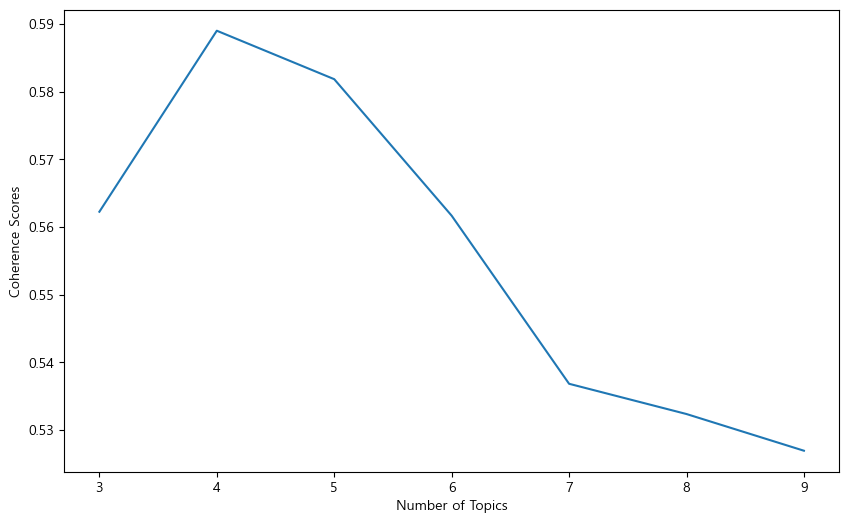

In [127]:
# coherence score 결과 시각화
import matplotlib.pyplot as plt

x = [i for i in range(min_topics, max_topics)]

plt.figure(figsize=(10,6))
plt.plot(x, coherence_score)
# x축 값 : 최소~최대 범위의 수
# y축 값 : 반복문으로 추출한 coherence_score
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.show()

# 토픽의 수가 21일때 가장 높은 점수를 보인다.

In [123]:
# 점수가 가장 높은 토픽수를 반영하여 다시 추출

lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, random_state=42)
topics = lda_model.print_topics(num_topics=3)
topics

[(0,
  '0.029*"쇼핑" + 0.025*"여행" + 0.020*"친구" + 0.019*"관광지" + 0.018*"전통" + 0.016*"가족" + 0.015*"코스" + 0.015*"연인" + 0.015*"곳" + 0.014*"문화"'),
 (1,
  '0.029*"아이" + 0.027*"여행" + 0.024*"서울" + 0.021*"쇼핑" + 0.020*"문화" + 0.019*"관광지" + 0.017*"가족" + 0.016*"전통" + 0.016*"체험" + 0.016*"역사"'),
 (2,
  '0.039*"관광지" + 0.037*"여행" + 0.031*"곳" + 0.020*"아이" + 0.019*"연인" + 0.019*"공간" + 0.018*"휴식" + 0.017*"가족" + 0.016*"서울" + 0.016*"친구"')]

In [124]:
# perplexity: 모델의 성능을 평가하는 지표로, 낮을수록 좋음

perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity}")

Perplexity: -6.043142510273193


토픽 모델링 시각화

In [125]:
# pyLDAvis : LDA 분석 결과를 시각화해주는 모듈
import pyLDAvis.gensim

# pyLDAvis의 노트북 모드를 활성화 >> Jupyter Notebook에서 시각화 결과를 바로 직접 볼 수 있도록 하기 위함
pyLDAvis.enable_notebook()

# pyLDAvis.gensim.prepare() : LDA 모델의 시각화 준비하는 코드
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

# 준비된 시각화를 노트북에서 표시
pyLDAvis.display(vis)

In [40]:
# pyLDAvis.save_html(vis, './관광_vis.html')

각 관광지가 어디 주제에 속하는 지 라벨링하는 코드

In [116]:
doc_topic_dist = lda_model[corpus]
doc_topic_dist

In [117]:
import pandas as pd

# 각 문서의 주제 분포를 수집할 리스트
doc_topic_list = []

for i, doc in enumerate(doc_topic_dist):
    # 각 문서의 주제 분포를 딕셔너리로 변환
    topic_probs = {f"Topic {topic_id}": prob for topic_id, prob in doc}
    # 문서 ID를 딕셔너리에 추가
    topic_probs["Document"] = i
    doc_topic_list.append(topic_probs)

# 리스트를 DataFrame으로 변환
doc_topic_df = pd.DataFrame(doc_topic_list)

# NaN 값을 0으로 대체
doc_topic_df = doc_topic_df.fillna(0)

doc_topic_df

,Topic 0,Topic 1,Topic 2,Topic 3,Document
0,0.553596,0.199048,0.013334,0.234022,0
1,0.020116,0.020244,0.019509,0.940130,1
2,0.268482,0.012122,0.707217,0.012178,2
3,0.757857,0.000000,0.222393,0.000000,3
4,0.927278,0.025598,0.023174,0.023949,4
...,...,...,...,...,...
331,0.021414,0.935485,0.021474,0.021627,331
332,0.033876,0.901979,0.031970,0.032175,332
333,0.023649,0.024097,0.024283,0.927971,333
334,0.000000,0.044519,0.939139,0.000000,334


In [118]:
df_tag_tour

,Attraction,Category,Tag,newTag,newTag_list,tag_word_N
0,104고지전적비,관광,#관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...,관광지 기념탑 역사 역사공부 역사관광지 역사를품은곳 역사문화재 역사속 역사속으로 역...,"[관광지, 기념탑, 역사, 역사공부, 역사관광지, 역사를품은곳, 역사문화재, 역사속...","[문화재, 유적지, 한국, 곳, 여행, 탐험, 역사, 공부, 비, 유적, 전쟁, 기..."
1,10꼬르소꼬모 청담점,관광,#10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...,10꼬르소꼬모 10꼬르소꼬모청담점 강남브런치카페 쇼핑 음식 청담동카페 청담동편집숍 ...,"[10꼬르소꼬모, 10꼬르소꼬모청담점, 강남브런치카페, 쇼핑, 음식, 청담동카페, ...","[카페, 청담, 꼬르소꼬모, 꼬르소꼬, 편집, 음식, 브런치, 청담동, 점, 숍, ..."
2,63아트,관광,#63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...,63빌딩전시관 63빌딩전시회 63스퀘어 63아트 경치좋은곳 문화공간 문화시설 문화예...,"[63빌딩전시관, 63빌딩전시회, 63스퀘어, 63아트, 경치좋은곳, 문화공간, 문...","[전망, 빌딩, 미술관, 전시관, 복합, 아트, 문화, 화공, 시설, 곳, 여행지,..."
3,가락농수산물종합도매시장,관광,#가락농수산물도매시장#가락시장#가족여행#나들이#나홀로여행#데이트코스#도심여행#먹거리...,가락농수산물도매시장 가락시장 가족여행 나들이 나홀로여행 데이트코스 도심여행 먹거리 ...,"[가락농수산물도매시장, 가락시장, 가족여행, 나들이, 나홀로여행, 데이트코스, 도심...","[수산물, 친구, 아이, 맛집, 쇼핑, 전통, 수도권, 농, 연인, 먹거리, 여행,..."
4,가락몰,관광,#가락몰#가락몰도서관#송파수산시장#쇼핑#식자재시장#식재료쇼핑몰,가락몰 가락몰도서관 송파수산시장 쇼핑 식자재시장 식재료쇼핑몰,"[가락몰, 가락몰도서관, 송파수산시장, 쇼핑, 식자재시장, 식재료쇼핑몰]","[식, 도서관, 쇼핑몰, 재료, 송파, 쇼핑, 가락, 식자, 수산시장, 재시]"
...,...,...,...,...,...,...
331,IFC몰,관광,#IFC몰#복합쇼핑몰#쇼핑#수도권#여의도대형쇼핑몰#여의도복합쇼핑몰#여의도쇼핑#여의도...,IFC몰 복합쇼핑몰 쇼핑 수도권 여의도대형쇼핑몰 여의도복합쇼핑몰 여의도쇼핑 여의도아...,"[IFC몰, 복합쇼핑몰, 쇼핑, 수도권, 여의도대형쇼핑몰, 여의도복합쇼핑몰, 여의도...","[여의도, 영등포, 연중, 복합, 쇼핑몰, 대형, 아이에프, 무, 크리스마스, 쇼핑..."
332,KCDF 갤러리숍 공예정원,관광,#갤러리숍#공예#공예품#디자인#디자인상품#쇼핑,갤러리숍 공예 공예품 디자인 디자인상품 쇼핑,"[갤러리숍, 공예, 공예품, 디자인, 디자인상품, 쇼핑]","[갤러리, 상품, 공예, 숍, 쇼핑, 공예품, 디자인]"
333,KT&G 상상마당 디자인스퀘어,관광,#기념품#문화활동#복합문화공간#쇼핑#외국인친구에게추천#홍대,기념품 문화활동 복합문화공간 쇼핑 외국인친구에게추천 홍대,"[기념품, 문화활동, 복합문화공간, 쇼핑, 외국인친구에게추천, 홍대]","[기념품, 친구, 복합, 공간, 문화, 추천, 쇼핑, 홍대, 활동, 외국인]"
334,N서울타워,관광,#19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...,19_20한국관광100선 2024_여행가는달과함께하는_발도장여행지 21_22한국관광...,"[19_20한국관광100선, 2024_여행가는달과함께하는_발도장여행지, 21_22한...","[명소, 전망, 친구, 아이, 사계절, 야간, 는달, 수도권, 선, 한국, 여행지,..."
